In [ ]:
import matplotlib.pyplot as plt

# Importing the dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive/cmepda_medphys_dataset/IMAGES/Mammography_micro/

README_micro.rtf  Test	Test.zip  Train  Train.zip


In [ ]:
!unzip -q /content/gdrive/My\ Drive/cmepda_medphys_dataset/IMAGES/Mammography_micro/Train.zip  -d /content/
!unzip -q /content/gdrive/My\ Drive/cmepda_medphys_dataset/IMAGES/Mammography_micro/Test.zip  -d /content/

In [ ]:
!ls /content/{Test,Train}

/content/Test:
0  1

/content/Train:
0  1


# Reading the images

In [ ]:
from skimage.io import imread
import os
import glob
import numpy as np

In [ ]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
    tmp += [ imread(fname) for fname in fnames ]
    labels += len(fnames)*[cls]
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

In [ ]:
train_dataset_path = '/content/Train'
x_train, y_train = read_imgs(train_dataset_path, [0, 1])

test_dataset_path = '/content/Test'
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(396, 60, 60, 1) (396,)
(401, 60, 60, 1) (401,)


# Defining a CNN model

In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation
from keras.models import Sequential

In [ ]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(8, (3,3), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPool2D((2,2)),
      
      Conv2D(16, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      MaxPool2D((2,2)),
        
      Conv2D(32, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Flatten(), 
      Dense(1, activation='sigmoid')
  ])
  
  return model

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 60, 60, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 16)        0

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.3, epochs=50, shuffle=True, callbacks=[checkpoint])

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7942
Epoch 00001: val_accuracy improved from -inf to 0.94958, saving model to model-01-0.95.hdf5
9/9 [==============================] - 1s 110ms/step - loss: 0.5156 - accuracy: 0.7942 - val_loss: 0.6600 - val_accuracy: 0.9496
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.7617
Epoch 00002: val_accuracy did not improve from 0.94958
9/9 [==============================] - 1s 88ms/step - loss: 0.4784 - accuracy: 0.7617 - val_loss: 0.7093 - val_accuracy: 0.3109
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.7942
Epoch 00003: val_accuracy did not improve from 0.94958
9/9 [==============================] - 1s 91ms/step - loss: 0.4386 - accuracy: 0.7942 - val_loss: 0.7892 - val_accuracy: 0.0168
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8159
Epoch 00004: val_accuracy did not improve fro

In [ ]:
model.save('/content/model.hdf5')

In [ ]:
!ls

# Data augmentation
 Before we can run data aumentation with ImageDataGenerator we need to convert the PGM format to PNG

In [ ]:
import PIL
import os

In [ ]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)


In [ ]:
for data_path in ['/content/Train', '/content/Test']:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)


In [ ]:
!ls /content/Test_png/

0  1


# Data aumentation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dataset_path = '/content/Train_png'
img_width, img_height = (60, 60)

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.3)
        
train_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')


Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [ ]:
train_gen.next()[0].shape

(32, 60, 60, 1)

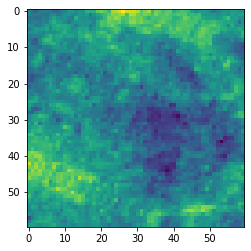

In [ ]:
plt.imshow(train_gen.next()[0][1].squeeze())

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [ ]:
from keras.optimizers import SGD

In [ ]:
model = make_model()
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size=32
history = model.fit(
        train_gen,
        steps_per_epoch=278 // batch_size,
        epochs=20,
        validation_data=val_gen,
        validation_steps= 118 // batch_size,
        callbacks=[checkpoint])

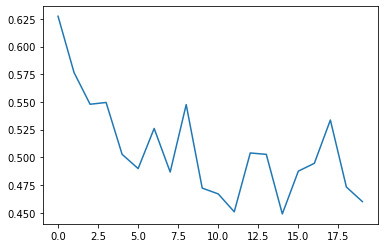

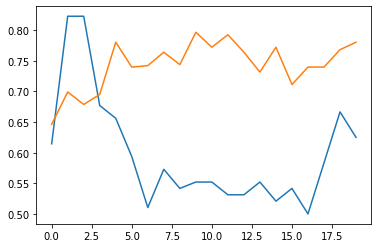

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.figure()
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])


# Saving the model

In [ ]:
!ls /content

gdrive			    model_augmented.02-0.49.h5	Test
model-01-0.95.hdf5	    model_augmented.02-0.82.h5	Test_png
model_augmented.01-0.47.h5  model_augmented.05-0.71.h5	Train
model_augmented.01-0.61.h5  sample_data			Train_png


In [ ]:
model.save('/content/model_augmented.hdf5')

In [ ]:
from keras.models import load_model

In [ ]:
imported_model = load_model('/content/model_augmented.hdf5')

In [ ]:
imported_model.summary()

# Evaluate the performances of the two models

In [ ]:
noaug_model = load_model('/content/model-01-0.95.hdf5')
aug_model = load_model('/content/model_augmented.02-0.82.h5')

In [ ]:
x_test, y_test = read_imgs('/content/Test', [0,1])

In [ ]:
noaug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 27ms/step - loss: 0.6789 - accuracy: 0.7107


[0.6788960099220276, 0.7107232213020325]

In [ ]:
aug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 27ms/step - loss: 0.6626 - accuracy: 0.7107


[0.6625624299049377, 0.7107232213020325]

# Visualizing

In [ ]:
model= load_model('/content/model_augmented.02-0.82.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 60, 60, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 16)        0

In [ ]:
model.layers


In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
micro_calc = val_gen.next()[0][2][np.newaxis,...]


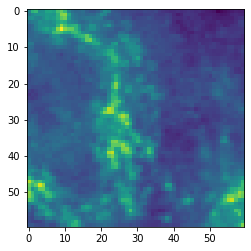

In [ ]:
plt.imshow(micro_calc.squeeze())

In [ ]:
activations = activation_model.predict(micro_calc)

In [ ]:
len(activations) == len(model.layers)

True

In [ ]:
activations[0].shape

(1, 60, 60, 8)

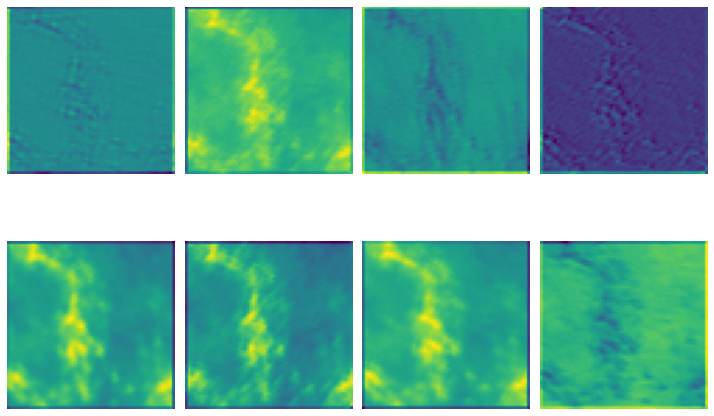

In [ ]:
fig = plt.figure(figsize=(10,10))
for k in range(8):
  plt.subplot(2,4, k+1)
  plt.imshow(activations[0][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.5, wspace=0.2)
fig.tight_layout(pad=1)

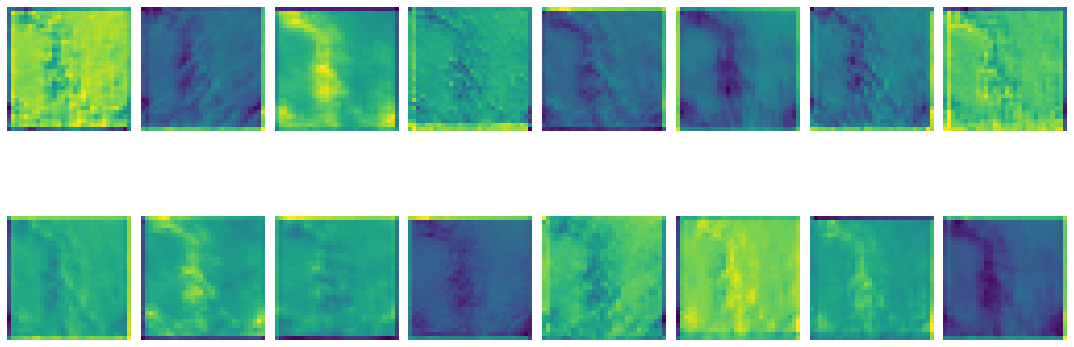

In [ ]:
fig = plt.figure(figsize=(15,15))

for k in range(16):
  plt.subplot(2,8, k+1)
  plt.imshow(activations[5][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

In [ ]:
fig = plt.figure(figsize=(15,15))
for k in range(32):
  plt.subplot(4,8, k+1)
  plt.imshow(activations[8][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

## Visualizing filters

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()

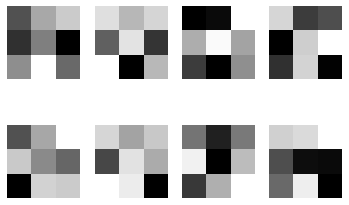

In [ ]:
for k in range(8):
  plt.subplot(2, 4, k+1)
  plt.imshow(filters[:,:,k], cmap='gray')
  plt.axis(False)

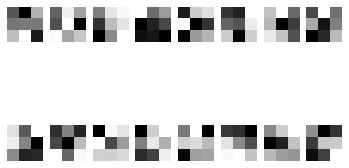

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[4].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()
for k in range(16):
  plt.subplot(2, 8, k+1)
  plt.imshow(filters[:,:,1 ,k], cmap='gray')
  plt.axis(False)

In [ ]:
filters.shape